In [1]:
# macro do ipython para rederizar o matplotlib inline
%matplotlib inline

# numpy é uma biblioteca de python que 
# nos permite fazer operações matriciais e vetoriais
# facilmente, e eficientemente (até um certo tamanho)
import numpy as np

import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import time

## Objetivo



### Carregando conjunto de dados

Vamos utilizar o mesmo conjunto de dados do notebook do SVM (aula_01). O conjunto de dados 20 newsgroups disponível no scikit-learn. Esse conjunto de dados possui aproximadamente 18000 newsgroups posts categorizados em 20 tópicos dividos em dois conjuntos: um para treino e outro para teste (em outras palavras, para avaliação de desempenho do modelo). A divisão entre conjunto de treino e teste basedo em mensagens postadas antes e depois uma data específica.


Vamos então carregá-lo e fazer a transformação para espaço vetorial como **bag-of-words** usando o scikit-learn.

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

train_20ng = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'quotes', 'footers'))
test_20ng = fetch_20newsgroups(subset='test', shuffle=False, remove=('headers', 'quotes', 'footers'))

# transforma dados textuais em uma representação vetorial usando
# bag-of-words
vec = CountVectorizer(stop_words='english', min_df=2)

X_train = vec.fit_transform(train_20ng.data)
y_train = train_20ng.target

X_test = vec.transform(test_20ng.data)
y_test = test_20ng.target

print("N. de Exmplos de Treino: %d; N. de Atributos: %d" % X_train.shape)
print("N. de Exmplos de Teste: %d; N. de Atributos: %d" % X_test.shape)

N. de Exmplos de Treino: 11314; N. de Atributos: 39115
N. de Exmplos de Teste: 7532; N. de Atributos: 39115


## Holdout

Vamos utilizar a técnica holdout para selecionar o parâmetro C do svm, profundidae máxima de um àrvore de Decisão, e o hiperparâmetro da regressão logística. Lembre-se que no holdout nós dividimos o conjunto de dados em 3 conjuntos distintos, um para treino (avaliação de performance), validação (seleção do modelo/parâmetros) e treino.

O scikit já divide o conjunto de dados em treino e teste, como pode ser notado acima. Desse modo vamos apenas dividir o conjunto de treino em dois (validação e treino).

In [3]:
from sklearn.model_selection import train_test_split
X_train_aux, X_valid, y_train_aux, y_valid = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

Quais valores de C escolher? Então, testar todos os valores de C pode ser inviável. Desse modo nós podemos chutar alguns valores que façam sentidos. Por exemplos, valores pequenos, médio e grandes, e assim testá-los.

In [4]:
Cs = 2. ** np.arange(-12, -2, 0.25)
Cs

array([ 0.00024414,  0.00029033,  0.00034527,  0.00041059,  0.00048828,
        0.00058067,  0.00069053,  0.00082119,  0.00097656,  0.00116134,
        0.00138107,  0.00164238,  0.00195312,  0.00232267,  0.00276214,
        0.00328475,  0.00390625,  0.00464534,  0.00552427,  0.0065695 ,
        0.0078125 ,  0.00929068,  0.01104854,  0.01313901,  0.015625  ,
        0.01858136,  0.02209709,  0.02627801,  0.03125   ,  0.03716272,
        0.04419417,  0.05255603,  0.0625    ,  0.07432544,  0.08838835,
        0.10511205,  0.125     ,  0.14865089,  0.1767767 ,  0.2102241 ])

Desse modo, para cada valor de C vamos aprender um modelo usando nosso ```X_train_aux``` e então avaliá-lo usando alguma métrica e o valores preditos no conjunto de ```X_valid```.

In [5]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.base import clone

svm = LinearSVC(random_state=0)

def holdout(clf, param_valores):
    best_score = 0
    best_param = 0
    for param, valores in param_valores.items():
        resultados = np.zeros((valores.shape[0], 4))
        
        # Para cada valor dos hiperparâmetro
        # nós criamos um modelo diferente com 
        # conjunto de treino auxiliar. 
        # Após termos o modelo com tal parâmetro,
        # fazemos a predição no conjunto de validação
        # e utilizamos alguma métrica para
        # obtermos um score para aquele método, e então,
        # escolher o paramêtro (ou conjunto de parâmetros)
        # gerou o modelo com maior score.
        for i, val in enumerate(valores):
            # clonando classificador e atribuindo o parametro
            classificador = clone(clf)
            classificador.set_params(**{param: val})
            
            # aprendendo um modelo baseado no conjunto de treino auxiliar
            classificador.fit(X_train_aux, y_train_aux)
            
            # predição baseada no conjunto de validação
            y_pred = classificador.predict(X_valid)

            # score para avaliação do modelo.
            score = f1_score(y_valid, y_pred, average="macro")

            # melhor parâmetro de acordo com score
            if best_score < score:
                best_score = score
                best_param = val

            # score no conjunto de validação, treino e teste para cada um dos valores do parâmetro
            # vamos utilizar isso para traçar a curva do compromisso viés e variância
            resultados[i, 0] = val
            resultados[i, 1] = 1 - score
            resultados[i, 2] = 1 - f1_score(y_train_aux, classificador.predict(X_train_aux), average="macro")
            resultados[i, 3] = 1 - f1_score(y_test, classificador.predict(X_test), average="macro")
        
    
    print("Melhor F1 : %f; Melhor %s : %f" % (best_score, param, best_param))
    return resultados, best_score, best_param

resultados, best_score, best_param = holdout(svm, {'C': Cs})           

Melhor F1 : 0.707446; Melhor C : 0.011049


In [6]:
svm.set_params(**{'C': best_param})
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

score = f1_score(y_test, y_pred, average="macro")
print("F1 no Teste: %f" % (score))

F1 no Teste: 0.645750


In [7]:
svm.set_params(**{'C': best_param})
svm.fit(X_train_aux, y_train_aux)
y_pred = svm.predict(X_valid)

score = f1_score(y_valid, y_pred, average="macro")
print("F1 no Teste: %f" % (score))

F1 no Teste: 0.707446


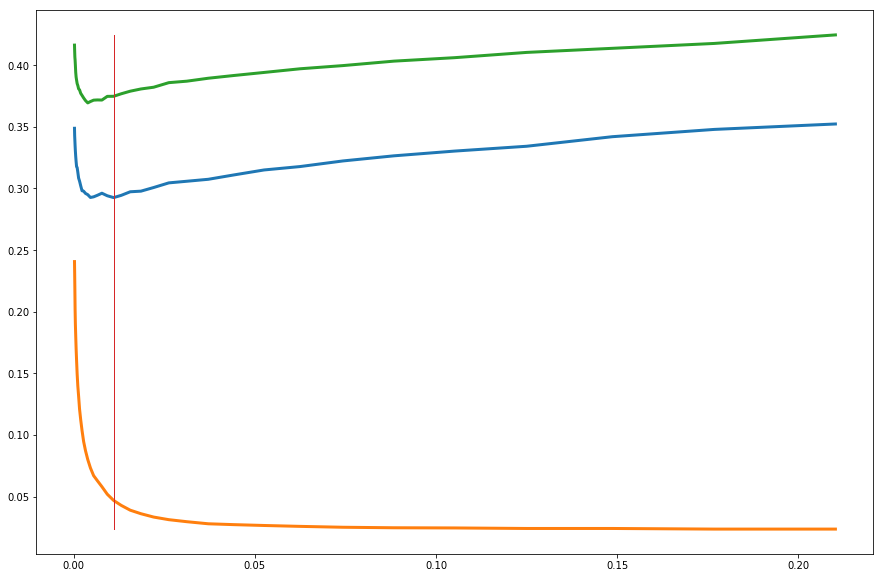

In [8]:
def plot_bias_variance_tradeoff(resultados, best_param = None):
    for j in range(resultados.shape[1] - 1):
        plt.plot(resultados[:, 0], resultados[:, j + 1],
                 linewidth=3)
    if best_param:
        plt.plot([best_param, best_param], [resultados[:,1:].min(), resultados[:,1:].max()],
                 linewidth=1)

plot_bias_variance_tradeoff(resultados, best_param)

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0, max_features=1.0)

profundidades = np.array([1, 5, 8, 25] + list(range(50, 130, 10)) + [200, 250, 300, 350, 500, 800, 1000])

resultados, best_score, best_param = holdout(dt, {'max_depth': profundidades})

/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Melhor F1 : 0.483397; Melhor max_depth : 200.000000


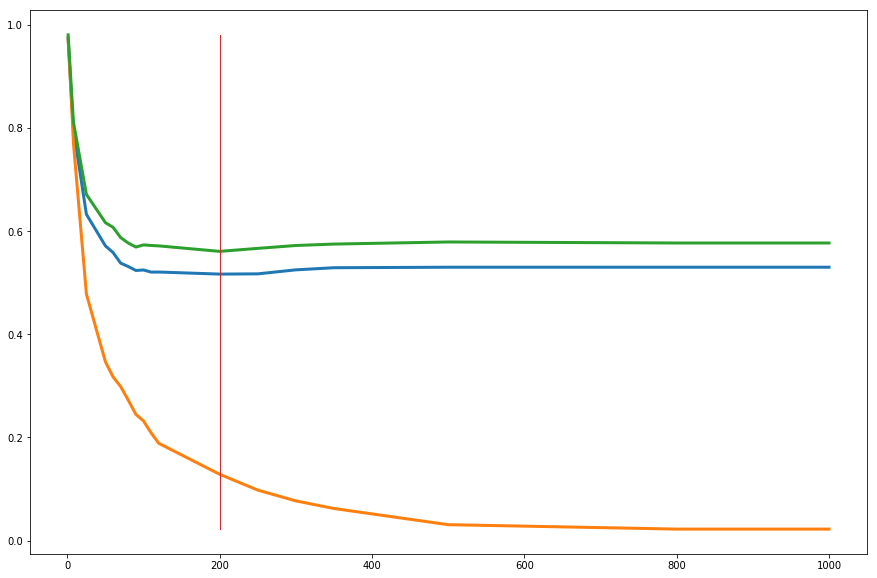

In [10]:
plot_bias_variance_tradeoff(resultados, best_param)

Melhor F1 : 0.693408; Melhor C : 0.250000


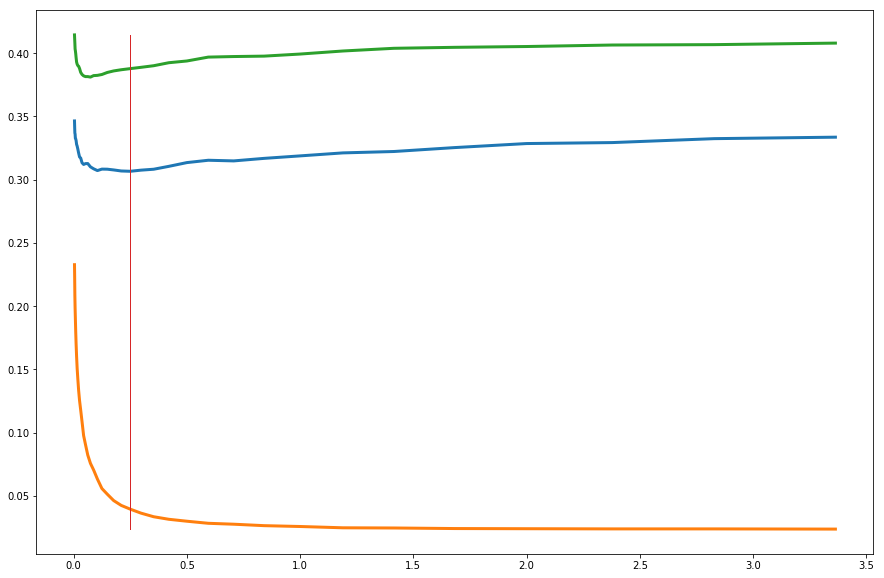

In [11]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(random_state=0, dual=True, n_jobs=-1)

Cs = 2. ** np.arange(-8, 2, 0.25)

resultados, best_score, best_param = holdout(lreg, {'C': Cs})
plot_bias_variance_tradeoff(resultados, best_param)

In [12]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

alphas = np.arange(0, 1, 0.1)

resultados, best_score, best_param = holdout(nb, {'alpha': alphas[::-1]})

Melhor F1 : 0.692122; Melhor alpha : 0.100000


/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


## Leave-one-out e Validação Cruzada

In [13]:
from sklearn.model_selection import LeaveOneOut

inicio = time.time()

loo = LeaveOneOut()
y_pred = np.zeros((X_train.shape[0]))
for index_train, index_valid in loo.split(X_train):
    X_train_aux, X_valid = X_train[index_train], X_train[index_valid]
    y_train_aux, y_valid = y_train[index_train], y_train[index_valid]
    
    nb.fit(X_train_aux, y_train_aux)
    y_pred[index_valid] = nb.predict(X_valid)
    
fim = time.time()
print("Melhor F1 : %f; Tempo : %.2f" % (f1_score(y_train, y_pred, average = "macro"), fim - inicio))

Melhor F1 : 0.682743; Tempo : 458.00


In [14]:
print("Melhor F1 : %f;" % (f1_score(y_test, nb.predict(X_test), average = "macro")))

Melhor F1 : 0.617610;


Leave-one-out é inviável quando temos muitos dados. Eu só estou utilizando para estimar o erro em teste, mesmo assim demora um tempão. Note que eu estou usando o naïve bayes para isso e ele é um dos métodos com processo de aprendizado mais rápido, portanto, é possível enxergar que esse método fosse utilizado para escolher o valor do hiperparâmetro serio praticamente impossível obtê-lo em um tempo aceitável.

O leave-one-out é um caso especial da validação cruzada (cross-validation), quando temos N conjuntos disjuntos. Na estratégia da validação cruzada, nós divitimos o conjunto de treino em K conjuntos de tamanho similar e disjuntos, chamados de ***Folds*** (**K-Fold Cross-Validation**). Modelo é aprendido utilizando K - 1 *folds*, o *fold* deixado de fora do treino é utilizado para predição e avaliação do modelo. Esse processo é repetido K vezes para que cada *fold* seja usado para predição ao menos uma vez. Avaliação final do modelo é dado pela média das avaliações em cada *fold*. 

No leave-one-out, nós temos que K = N (quantidade de exemplos no conjunto de treino). 

T. Hastie, R. Tibshirani, J. Friedman, The Elements of Statistical Learning, Springer 2009

In [15]:
from sklearn.model_selection import validation_curve, KFold

ordered = np.argsort(y_train)

Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 5)
train_scores, valid_scores = validation_curve(svm, X_train[ordered], y_train[ordered], 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rcampos/projects/amb009/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/

Melhor F1 : 0.034786; Melhor C : 0.044194


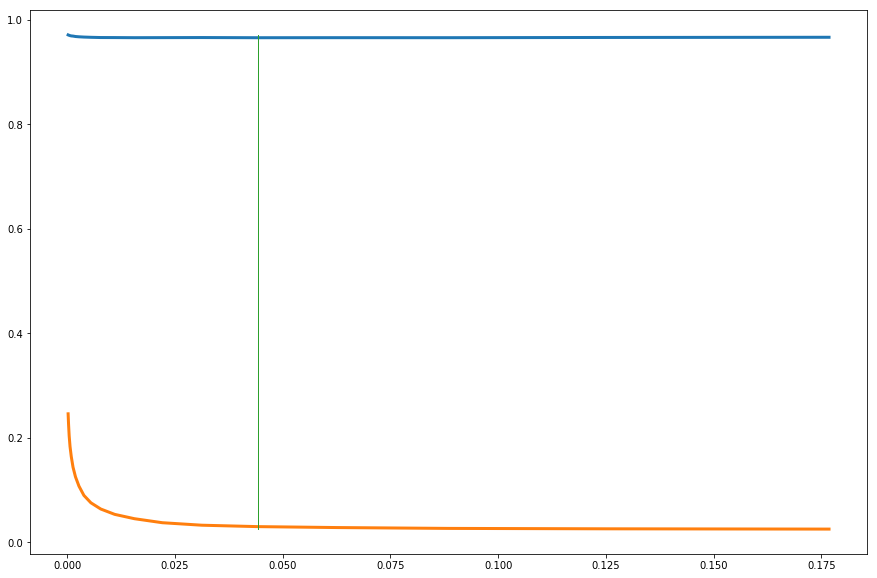

In [16]:
mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, Cs[best_param_index])

Melhor F1 : 0.718348; Melhor C : 0.007812


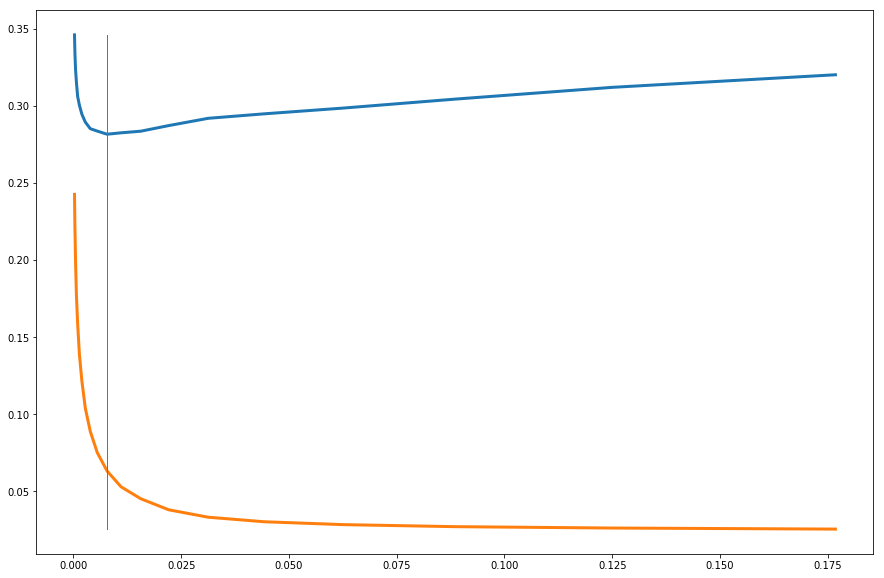

In [17]:
# ordered = np.argsort(y_train)
Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 5)
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, Cs[best_param_index])

Melhor F1 : 0.724257; Melhor C : 0.015625


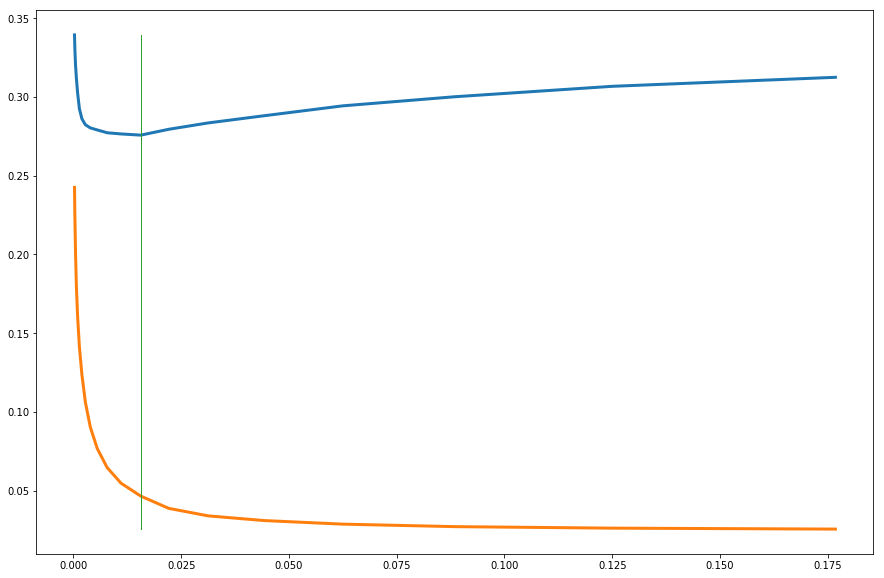

In [18]:
Cs = 2. ** np.arange(-12, -2, 0.5)
cv = KFold(n_splits = 10)
train_scores, valid_scores = validation_curve(svm, X_train, y_train, 'C', Cs, cv=cv, n_jobs=-1, scoring='f1_macro')

mean_valid_score = valid_scores.mean(1)
mean_train_score = train_scores.mean(1)

best_param_index = np.argmax(mean_valid_score)

print("Melhor F1 : %f; Melhor C : %f" % (mean_valid_score[best_param_index], Cs[best_param_index]))

resultados = np.vstack((Cs, 1 - mean_valid_score, 1 - mean_train_score)).T
plot_bias_variance_tradeoff(resultados, Cs[best_param_index])

### Calibrando mais de um hiperparâmetro

E quando o modelo possui mais de um hiperparâmetro, como fazer a calibragem?

- Fazer a calibragem individual de cada um deles, sempre escolhendo o melhor valor para cada hiperparâmetro individual.
  
  - Não leva em consideração que os hiperparâmtros podem afetar uns aos outros
  - Menos custo
  
- Usar um tática força bruta, e tentar todas as combinações de hiperparâmetros. Essa técnica é conhecida como GridSearch
  - Pode ser muito custosa computacionalmente

- Fazer uma exploração aleatória em busca dos melhores valores
  - Computanionalmente melhor que GridSearch, porém pode ser resultar em o modelo pior que usando a técnica do GridSearch.
    
  
Scikit-learn nos oferece formas simples tanto de fazer um gridsearch quanto fazer uma busca aleatória, respectivamente com os modulos, **GridSearchCV** e **RandomizedSearchCV**.

In [ ]:
"""Colocar link da documentação"""
svm

LinearSVC(C=0.011048543456039806, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=0,
     tol=0.0001, verbose=0)

Além do hiperparâmetro C, a implementação do SVM linear disponibilizada pelo Scikit-learn tem outros parâmetros que influenciam o aprendizado do modelo, e portanto, sua predição final. Dessa forma, podemos calibrá-los juntamente com C.

Vamos então fazer isso utilizando o  **GridSearchCV** e **RandomizedSearchCV** do scikit.

In [ ]:
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': 2. ** np.arange(-12, -2, 0.5),
    'class_weight': [None, 'balanced'],
             }
grid = GridSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s


In [ ]:
print("Melhores parâmetros: %s; Melhor F1: %f" % (grid.best_params_, grid.best_score_))
print("Teste F1: %f" % (f1_score(y_test, grid.predict(X_test), average='macro')))

In [ ]:
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

param_grid = {
    'C': 2. ** np.arange(-12, -2, 0.5),
    'class_weight': [None, 'balanced'],
             }
rand = RandomizedSearchCV(svm, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1, random_state=0)

rand.fit(X_train, y_train)

In [ ]:
print("Melhores parâmetros: %s; Melhor F1: %f" % (rand.best_params_, rand.best_score_))
print("Teste F1: %f" % (f1_score(y_test, rand.predict(X_test), average='macro')))

Além do hiperparâmetros do algoritmo de aprendizado de máquinas, outros fatores influenciam no aprendizado de um determinado modelo. Esse fatores podem ser, os atributos e as transformações que fazemos nos atributos, os kernels do svm e assim por diante. Nesse contexto, vamos mostrar como construir um pipeline para seleção de atributos, criação e enriquecimento de atributos. E isso tudo nós temos de escolher empiricamente, e cada combinação desse fatores gerará um modelo distinto e devemos escolher o melhor dentre eles para nós colocarmos em produção.


Ainda no contexto de classificação de textual vamos então escolher os melhores atributos, enriquecer e criar novos atributos na esperança de melhorar obtermos modelos melhores.